In [1]:
from ai_assets import *

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array


def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test


def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_' +
                  group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_' +
                  group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_' +
                  group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group(
        'train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group(
        'test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ", trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    pyplot.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        pyplot.hist(longX[:, i], bins=100)
    pyplot.show()

(470528, 9)


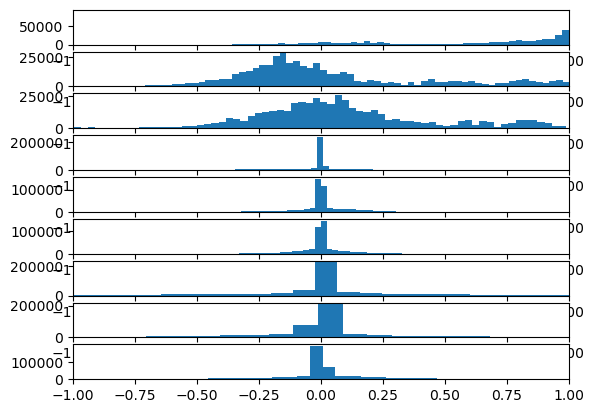

In [5]:
# plot distributions
plot_distributions(trainX)

In [6]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

### CNN+LSTM model

In [23]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu',
          input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu',
          input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 125, 64)           2368      
                                                                 
 conv1d_3 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout_3 (Dropout)         (None, 122, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 61, 64)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [25]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size,
                    verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 8s 65ms/step - loss: 0.8803 - accuracy: 0.6443 - val_loss: 0.5568 - val_accuracy: 0.7954
Epoch 2/20
92/92 [==============================] - 6s 62ms/step - loss: 0.3678 - accuracy: 0.8711 - val_loss: 0.3345 - val_accuracy: 0.8939
Epoch 3/20
92/92 [==============================] - 6s 61ms/step - loss: 0.2310 - accuracy: 0.9235 - val_loss: 0.3323 - val_accuracy: 0.8980
Epoch 4/20
92/92 [==============================] - 6s 61ms/step - loss: 0.2679 - accuracy: 0.9112 - val_loss: 0.3339 - val_accuracy: 0.8858
Epoch 5/20
92/92 [==============================] - 6s 64ms/step - loss: 0.1665 - accuracy: 0.9434 - val_loss: 0.3279 - val_accuracy: 0.8987
Epoch 6/20
92/92 [==============================] - 6s 67ms/step - loss: 0.1706 - accuracy: 0.9373 - val_loss: 0.2436 - val_accuracy: 0.8994
Epoch 7/20
92/92 [==============================] - 6s 68ms/step - loss: 0.1374 - accuracy: 0.9495 - val_loss: 0.2457 - val_accuracy: 0.9089
Epoch 8/20
92

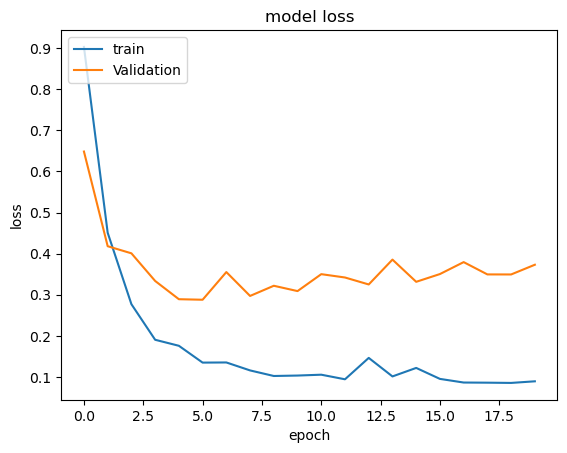

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [14]:
# evaluate model
test_loss, test_accuracy = model.evaluate(
    testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions = model.predict(testX)

Accuracy of the CNN model 0.9043094515800476
93/93 [==============================] - 1s 10ms/step


In [16]:
def display_results(testy, predictions, classNames):
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # /np.sum(cm[x,:])

    plt.figure(figsize=(10, 8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',
                     xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[469   0  27   0   0   0]
 [  5 439  27   0   0   0]
 [  7   2 411   0   0   0]
 [  0  24   0 395  72   0]
 [  1   0   0  74 457   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       496
           2       0.86      0.93      0.90       471
           3       0.88      0.98      0.93       420
           4       0.84      0.80      0.82       491
           5       0.86      0.86      0.86       532
           6       1.00      0.92      0.96       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.91      0.90      0.90      2947



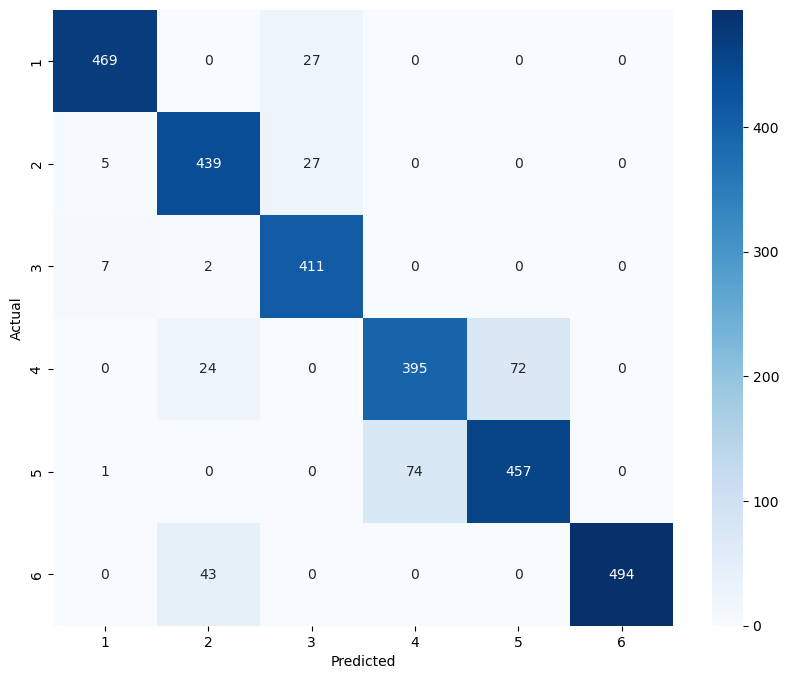

In [18]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

Predicting for a single sample

In [20]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [21]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(
    sample.reshape(1, sample.shape[0], sample.shape[1]))

1/1 [==============================] - 0s 21ms/step


In [22]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ", sampleActualClass[0])
print("Predicted class: ", samplePredictedClass[0])

Actual class:  4
Predicted class:  4
